# Notebook details

In [1]:
def setup_notebook(fix_python_path=True, reduce_margins=True, plot_inline=True):
    if reduce_margins:
        # Reduce side margins of the notebook
        from IPython.core.display import display, HTML
        display(HTML("<style>.container { width:100% !important; }</style>"))

    if fix_python_path:
        # add egosocial to the python path
        import os, sys
        sys.path.extend([os.path.dirname(os.path.abspath('.'))])

    if plot_inline:
        # Plots inside cells
        %matplotlib inline

setup_notebook()

# Imports and Constants Definition

In [2]:
# !/usr/bin/env python
# -*- coding: utf-8 -*-

import argparse
from collections import defaultdict
import logging
import matplotlib.pyplot as plt
import os
import shutil
import sys
import threading

import numpy as np

import keras
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers import Input, Dense, Dropout, Cropping2D, GlobalMaxPooling2D
from keras.layers.noise import AlphaDropout
from keras.models import Model
from keras.regularizers import l2
from keras.utils import to_categorical

import egosocial
from egosocial.core.types import relation_to_domain, relation_to_domain_vec
from egosocial.utils.filesystem import create_directory, check_directory
from egosocial.utils.logging import setup_logging
from egosocial.utils.keras.autolosses import AutoMultiLossWrapper, AutoMultiLossLayer
from egosocial.utils.keras.backend import limit_gpu_allocation_tensorflow
from egosocial.utils.keras.callbacks import PlotLearning
from egosocial.utils.keras.utils import flow_from_dirs, fuse_inputs_generator

# TODO: move these constants to the library
DOMAIN, RELATION = 'domain', 'relation'
END_TO_END, ATTRIBUTES = 'end_to_end', 'attributes'
N_CLS_RELATION, N_CLS_DOMAIN = 16, 5
RELATION_LABELS = [str(label) for label in range(N_CLS_RELATION)]
FILE_FORMAT = '{prefix}{dtype}{idx}_{split}_{n_cls}{ext}'

MODEL_INPUTS = ('body/1', 'body/2', 'face/1', 'face/2')
IMAGE_SHAPE = (256, 256, 3)
INPUT_SHAPE = (227, 227, 3)
SHARED_SEED = 1
STREAM_IDS = [str(idx) for idx in [1, 2]]

DEPRECATED_HOME = '/root/'
NEW_HOME='/home/'

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Limit GPU memory allocation with Tensorflow

In [3]:
limit_gpu_allocation_tensorflow(0.5)

# Input arguments and fake main

In [4]:
def get_file(split, idx=1, dtype='body', n_cls=N_CLS_RELATION, 
             ext='.txt', prefix='single_'):
    return FILE_FORMAT.format(split=split, prefix=prefix, dtype=dtype, 
                              idx=idx, n_cls=n_cls, ext=ext)

class Configuration:
    def __init__(self, args):
        # setup directories
        self.PROJECT_DIR = args.project_dir

        self.SPLITS_DIR = os.path.join(self.PROJECT_DIR,
                                       'datasets/splits/annotator_consistency3')

        # splits (switch from caffe's split name convention to keras's convention)        
        _train, _val, _test = 'train', 'test', 'eval'        
        self.LABEL_FILES = {split: os.path.join(self.SPLITS_DIR, get_file(split=split))
                            for split in (_train, _val, _test)}

        self.EPOCHS = args.epochs
        self.BATCH_SIZE = args.batch_size

        # reuse precomputed model?
        self.REUSE_MODEL = args.reuse_model
        # save model to disk?
        self.SAVE_MODEL = args.save_model
        # save model statistics to disk?
        self.SAVE_STATS = args.save_stats
        
        self.FAKE_DIR = os.path.join(self.PROJECT_DIR, 'datasets', 'fake_dir')
        
def positive_int(value):
    ivalue = int(value)
    if ivalue <= 0:
        raise argparse.ArgumentTypeError(
            "%s is an invalid positive int value" % value)
    return ivalue

def main(*fake_args):
    setup_logging(egosocial.config.LOGGING_CONFIG)

    entry_msg = 'Reproduce experiments in Social Relation Recognition paper.'
    parser = argparse.ArgumentParser(description=entry_msg)

    parser.add_argument('--project_dir', required=True,
                        help='Base directory.')

    parser.add_argument('--reuse_model', required=False,
                        action='store_true',
                        help='Use precomputed model if available.')

    parser.add_argument('--save_model', required=False,
                        action='store_true',
                        help='Save model to disk.')

    parser.add_argument('--save_stats', required=False,
                        action='store_true',
                        help='Save statistics to disk.')

    parser.add_argument('--epochs', required=False, type=positive_int,
                        default=100,
                        help='Max number of epochs.')

    parser.add_argument('--batch_size', required=False, type=positive_int,
                        default=32,
                        help='Batch size.')

    # TODO: implement correctly
    args = parser.parse_args(*fake_args)
    # keep configuration
    conf = Configuration(args)
    # check directories
    check_directory(conf.PROJECT_DIR, 'Project')
    check_directory(conf.SPLITS_DIR, 'Splits')
    
    return conf

# Helper functions

In [5]:
# TODO: move to utils
class AttributeSelector:
    def __init__(self, all_attrs):
        body_attributes = self.filter_by_keyword(all_attrs, 'body')
        face_attributes = self.filter_by_keyword(all_attrs, 'face')
        face_attributes.extend(self.filter_by_keyword(all_attrs, 'head'))

        self._selector = {'all': all_attrs,
                          'body': body_attributes,
                          'face': face_attributes}

    def filter(self, query):
        query = query.lower()
        if query in self._selector:
            selected_attributes = self._selector[query]
        else:
            selected_attributes = self.filter_by_keyword(self._selector['all'],
                                                         query)

        return selected_attributes

    def filter_by_keyword(self, attribute_list, key):
        return [attr_name for attr_name in attribute_list if key in attr_name]


# TODO: move to utils
def get_relation_domain(data_batch, inputs):
    # relation output (every attribute has the same output)
    y_rel = data_batch[0][1] # indices 0: first input, 1: label data
    # inverse of function to_categorical
    plain_y_rel = np.argmax(y_rel, axis=1)
    # final output is domain, relation
    y_dom = to_categorical(relation_to_domain_vec(plain_y_rel), N_CLS_DOMAIN)
    
    return dict(domain=y_dom, relation=y_rel)

# TODO: move to utils
def create_data_split_generators(directory, 
                                 train_gen_args=None, 
                                 test_val_gen_args=None,
                                 fix_path_cbk=None,
                                 **kwargs):
    check_directory(directory)
    
    inputs = list(MODEL_INPUTS)
    def input_dirs(split):
        return [os.path.join(directory, input_name, split) 
                for input_name in inputs]

    # splits (switch from caffe's split name convention to keras's convention)    
    _train, _val, _test = 'train', 'test', 'eval'
        
    split_gen_args = [ (_train, train_gen_args)
                     , (_val, test_val_gen_args)
                     , (_test, test_val_gen_args)]

    split_generators = []
    for split, gen_args in split_gen_args:
        gens = flow_from_dirs(
            input_dirs(split), 
            gen_args=gen_args,
            fix_path_cbk=fix_path_cbk,
            **kwargs
        )
        
        fused_gen = fuse_inputs_generator(
            gens, inputs, 
            outputs_callback=get_relation_domain
        )
        
        split_generators.append(fused_gen)
        
    return split_generators

def process_line(line):
    image_path, label = line.strip().rsplit(' ', 1)

    if image_path.startswith(DEPRECATED_HOME):
        image_path = os.path.join(NEW_HOME, image_path[len(DEPRECATED_HOME):])

    return image_path, label

class FakeDirectory:

    def __init__(self, fake_dir, splits_dir):
        self.fake_dir = fake_dir
        self.splits_dir = splits_dir 
                
        self._fake_link_fmt = 'fakelink{}_{}'
        self._file_map = {}
        
    def create_structure(self):
        
        self._file_map = {}
        
        if os.path.isdir(self.fake_dir):
            shutil.rmtree(self.fake_dir)

        create_directory(self.fake_dir, 'Fake')

        for dtype in ('body', 'face'):
            dtype_dir = os.path.join(self.fake_dir, dtype)
            create_directory(dtype_dir, 'Fake {}'.format(dtype))

            # set dtype to body or face
            file_callback = lambda **kwargs: get_file(dtype=dtype, **kwargs)      

            mapping = self._get_split_mapping(file_callback=file_callback)

            for images_dir, images_file in mapping.items():
                fake_images_dir = os.path.join(dtype_dir, images_dir)

                images_file_path = os.path.join(self.splits_dir, images_dir, images_file)
                with open(images_file_path) as f:
                    for fake_id, line in enumerate(f):
                        image_path, label = process_line(line)
                        
                        fake_label_dir = os.path.join(fake_images_dir, str(label))

                        # keras asks for a different directory for each class
                        if not os.path.exists(fake_label_dir):
                            create_directory(fake_label_dir, 'Label')                            
                        
                        # create symlinks for every entry
                        # a name may appear in several entries, so an unique fake name is created
                        fake_name = self._fake_link_fmt.format(fake_id, os.path.basename(image_path))
                        fake_path = os.path.join(fake_label_dir, fake_name)
                        
                        # keep mapping fakefile -> image_path
                        self._file_map[fake_path] = image_path

                        os.symlink(image_path, fake_path)


    def _get_split_mapping(self, file_callback=get_file):
        # splits (switch from caffe's split name convention to keras's convention)
        _train, _val, _test = 'train', 'test', 'eval'

        check_directory(self.splits_dir, 'Splits')

        mapping = {}

        for split in (_train, _val, _test):
            for idx in STREAM_IDS:
                key = '{idx}{sep}{split}'.format(split=split, sep=os.path.sep, idx=idx)
                value =  os.path.join(self.splits_dir, file_callback(split=split, idx=idx))
                mapping[key] = value

        return mapping

    def fix_fake_link(self, directory, filename):

        fake_path = os.path.join(directory, filename)
        assert fake_path in self._file_map        
        image_path = self._file_map[fake_path]

        fake_label_dir = os.path.split(fake_path)[0]
        label = os.path.split(fake_label_dir)[1]

        original_dir, basename = os.path.split(image_path)

        # common ancestor
        commonprefix = os.path.commonprefix([original_dir, directory])
        # remove commonprefix
        fake_subdir = directory[len(commonprefix):]        
        original_subdir = original_dir[len(commonprefix):]
        # go up in fake path up to common prefix, then go down the real path 
        go_up = os.path.join(*['..' for folder in fake_subdir.split(os.path.sep)])    
        go_down = original_subdir

        fixed_filename = os.path.join(go_up, go_down, basename)
        return fixed_filename

# Main class

In [6]:
class SocialClassifier:
    
    def __init__(self, data_dir):
        self._data_dir = data_dir

        self._log = logging.getLogger(self.__class__.__name__)
        
        # initialize when model is configured
        self._model_wrapper = None
        self.model = None
        
        self._train_gen, self._val_gen, self._test_gen = None, None, None
    
    def setup_datagen(self, **kwargs):
        self._log.debug("Creating data generators.")        

        train_gen_args = dict(
            rescale=1./255,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.1,
            zoom_range=0.2,
            rotation_range=20,
            horizontal_flip=True,
            preprocessing_function=preprocess_input,
        )
        test_val_gen_args = dict(
            rescale=1./255,
            preprocessing_function=preprocess_input,
        )
        
        split_gens = create_data_split_generators(
            self._data_dir, train_gen_args, test_val_gen_args,
            **kwargs
        )
        
        self._train_gen, self._val_gen, self._test_gen = split_gens    
        
    def set_model(self, model, optimizer='adam', 
                  loss='categorical_crossentropy', 
                  loss_weights='auto',
                  **kwargs):
        assert model
        self._log.debug("Initializing model.")
        
        # wrapper allows to train the loss weights
        self._model_wrapper = AutoMultiLossWrapper(model)
        self._model_wrapper.compile(optimizer, loss, 
                                    loss_weights=loss_weights, 
                                    **kwargs)

        self.model = self._model_wrapper.model
        self._log.info(self.model.summary())
        
    def fit(self, steps_per_epoch, validation_steps, **kwargs):
        assert self.model
        assert self._train_gen
        assert self._val_gen
        self._log.debug("Training model from scratch.")        

        # train the model on the new data for a few epochs
        return self.model.fit_generator(
            self._train_gen,
            steps_per_epoch=steps_per_epoch,
            validation_data=self._val_gen,
            validation_steps=validation_steps,
            **kwargs
        )
        
    def evaluate(self, steps, **kwargs):
        assert self.model
        assert self._test_gen
        self._log.debug("Evaluating model in test data.")
        
        return self.model.evaluate_generator(
            self._test_gen,
            steps=steps,
            **kwargs
        )

# Model definitions

In [7]:
from egosocial.config import MODEL_KEYS, MODELS
from egosocial.utils.keras.layers import LRN

MODELS_CACHE_DIR = '/home/shared/Documents/final_proj/models/keras_models/models_keras_repr'
MODELS_CACHE_SUBDIR = 'bins'

def get_models(attributes):
    models = {}

    for attr in attributes:
        file, url =  MODELS[attr]
        
        model_file = keras.utils.get_file(
            file, url,
            cache_dir=MODELS_CACHE_DIR, cache_subdir=MODELS_CACHE_SUBDIR,
        )
        
        models[attr] = keras.models.load_model(model_file, 
                                              custom_objects={'LRN': LRN})
    
    return models

In [8]:
def create_model_top_down(input_features):
    x = input_features
    x = keras.layers.BatchNormalization()(x)
    
    x = Dense(64, name='fc_features',
                  activation='selu',
                  bias_initializer='lecun_normal',
                  kernel_initializer='lecun_normal',
                  bias_regularizer=l2(0.01),
                  kernel_regularizer=l2(0.01),              
              )(x)
    x = keras.layers.BatchNormalization()(x)
    x = AlphaDropout(0.25)(x)

    domain = Dense(N_CLS_DOMAIN, name='domain',
                   activation='softmax',
                   bias_regularizer=l2(0.01),
                   kernel_regularizer=l2(0.01),
                  )(x)

    x = keras.layers.concatenate([x, domain])
    
    relation = Dense(N_CLS_RELATION, name='relation',
                     activation='softmax',
                     bias_regularizer=l2(0.01),
                     kernel_regularizer=l2(0.01),
                    )(x)

    return [domain, relation]

class ModelFactory:
    
    def __init__(self, input_shape, image_shape=None):
        self.input_shape = input_shape
        self.image_shape = image_shape if image_shape else input_shape

        self._layer_name_fmt = "{}_attribute_{}"

    def create(self, model_inputs, models, **kwargs):
        freeze_attributes = kwargs.get('freeze_attributes', False)
        features_layer = kwargs.get('features_layer', 'pool5')

        # collect model inputs and crop them if needed
        inputs, cropped_inputs = self._get_inputs(model_inputs)
        # update layer name and freeze weights if neccesary
        for model_set in models.values():
            for attr_name, model in model_set.items():
                self._update_model(model, attr_name, 
                                   freeze_weights=freeze_attributes)

        # collect features from all attribute models
        feature_outputs = self._get_features(cropped_inputs, models, features_layer)
        # concatenate features        
        fused_features = keras.layers.concatenate(feature_outputs)        
        # feature downsampling
        fused_features = GlobalMaxPooling2D()(fused_features)

        model = Model(
            inputs=inputs,
            outputs=create_model_top_down(fused_features)
        )

        return model

    def _get_inputs(self, model_inputs):        
        # cropping dimensions
        diff_shape = (np.array(self.image_shape[:2]) - np.array(self.input_shape[:2])) / 2.0
        crop_size = tuple(map(int, diff_shape))
        assert crop_size[0] >= 0 and crop_size[1] >= 0

        # collect model inputs and crop them if needed
        inputs, cropped_inputs = [], []
        for input_name in model_inputs:
            _input = Input(shape=self.image_shape, name=input_name)        
            # crop image if neccesary
            if self.input_shape != self.image_shape:
                cropped_input = Cropping2D(
                    crop_size, name="cropped_%s" % input_name
                )(_input)
            else:
                cropped_input = _input

            inputs.append(_input)
            cropped_inputs.append(cropped_input)
            
        return inputs, cropped_inputs
    
    def _get_features(self, inputs, models, features_layer):
        # includes features from all attributes
        feature_outputs = []
        # get image types that are grouped together (e.g. body, face, context)
        im_types = models.keys()
        for im_type in im_types:            
            type_inputs, type_outputs = self._get_image_type_inputs_outputs(
                models[im_type], features_layer
            )

            # model that fuses features from a given image type
            fused_attrs = Model(inputs=type_inputs, outputs=type_outputs)
            fused_attrs.name = 'features_{}'.format(im_type)        
            # collect features from a given image type
            for _input in inputs:
                if im_type in _input.name:
                    attr_output = fused_attrs([_input] * len(fused_attrs.inputs))
                    feature_outputs.extend(attr_output)

        return feature_outputs

    def _get_image_type_inputs_outputs(self, image_type_models, features_layer):
        # includes inputs and outputs for a given type
        attr_inputs, attr_outputs = [], []
        for attr_name, attr_model in image_type_models.items():
            # collect attribute inputs
            attr_inputs.append(attr_model.input)
            # collect attribute outputs
            features_layer_attr = self._layer_name_fmt.format(features_layer, attr_name)
            attr_outputs.append(attr_model.get_layer(features_layer_attr).output)

        return attr_inputs, attr_outputs
        
    def _update_model(self, model, attr_name, freeze_weights=False):
        for layer in model.layers:
            # freeze inherited attribute weights
            layer.trainable = not freeze_weights
            # rename layers if neccesary
            if attr_name not in layer.name:
                layer.name = self._layer_name_fmt.format(layer.name, attr_name)

# Fake call to main to process inputs arguments

In [9]:
args = [
    "--project_dir", "/home/shared/Documents/final_proj",
    "--epochs", "30",
    "--batch_size", "64",
]

conf = main(args)

2018-02-21 17:11:31,906 - egosocial.utils.filesystem - DEBUG - Checked Project directory: /home/shared/Documents/final_proj
2018-02-21 17:11:31,906 - egosocial.utils.filesystem - DEBUG - Checked Splits directory: /home/shared/Documents/final_proj/datasets/splits/annotator_consistency3


# Prepate the data

In [10]:
fakedir = FakeDirectory(conf.FAKE_DIR, conf.SPLITS_DIR)
fakedir.create_structure()

2018-02-21 17:11:33,166 - egosocial.utils.filesystem - DEBUG - Creating Fake directory /home/shared/Documents/final_proj/datasets/fake_dir
2018-02-21 17:11:33,167 - egosocial.utils.filesystem - DEBUG - Creating Fake body directory /home/shared/Documents/final_proj/datasets/fake_dir/body
2018-02-21 17:11:33,168 - egosocial.utils.filesystem - DEBUG - Checked Splits directory: /home/shared/Documents/final_proj/datasets/splits/annotator_consistency3
2018-02-21 17:11:33,168 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/1/train/15
2018-02-21 17:11:33,169 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/1/train/4
2018-02-21 17:11:33,170 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/1/train/12
2018-02-21 17:11:33,171 - egosocial.utils.filesystem - DEBUG - Creating Label direc

2018-02-21 17:11:34,576 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/2/test/15
2018-02-21 17:11:34,577 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/2/test/4
2018-02-21 17:11:34,578 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/2/test/5
2018-02-21 17:11:34,579 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/2/test/12
2018-02-21 17:11:34,580 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/2/test/8
2018-02-21 17:11:34,581 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/body/2/test/6
2018-02-21 17:11:34,587 - egosocial.utils.filesystem - DEBUG - Creating La

2018-02-21 17:11:35,126 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/train/8
2018-02-21 17:11:35,126 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/train/5
2018-02-21 17:11:35,128 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/train/6
2018-02-21 17:11:35,132 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/train/9
2018-02-21 17:11:35,136 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/train/10
2018-02-21 17:11:35,138 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/train/3
2018-02-21 17:11:35,143 - egosocial.utils.filesystem - DEBUG - Creati

2018-02-21 17:11:36,749 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/2/test/11
2018-02-21 17:11:36,750 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/2/test/13
2018-02-21 17:11:36,755 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/eval/8
2018-02-21 17:11:36,756 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/eval/4
2018-02-21 17:11:36,756 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/eval/7
2018-02-21 17:11:36,757 - egosocial.utils.filesystem - DEBUG - Creating Label directory /home/shared/Documents/final_proj/datasets/fake_dir/face/1/eval/15
2018-02-21 17:11:36,758 - egosocial.utils.filesystem - DEBUG - Creating L

In [11]:
batch_size = conf.BATCH_SIZE

helper = SocialClassifier(conf.FAKE_DIR)

helper.setup_datagen(
    batch_size=batch_size,
    seed=SHARED_SEED,
    classes=RELATION_LABELS,
    target_size=IMAGE_SHAPE[0:2],
    fix_path_cbk=fakedir.fix_fake_link,
)

2018-02-21 17:11:37,456 - SocialClassifier - DEBUG - Creating data generators.
2018-02-21 17:11:37,456 - egosocial.utils.filesystem - DEBUG - Checked  directory: /home/shared/Documents/final_proj/datasets/fake_dir
2018-02-21 17:11:37,457 - egosocial.utils.filesystem - DEBUG - Checked  directory: /home/shared/Documents/final_proj/datasets/fake_dir/body/1/train
Found 13729 images belonging to 16 classes.
2018-02-21 17:11:38,197 - egosocial.utils.filesystem - DEBUG - Checked  directory: /home/shared/Documents/final_proj/datasets/fake_dir/body/2/train
Found 13729 images belonging to 16 classes.
2018-02-21 17:11:38,940 - egosocial.utils.filesystem - DEBUG - Checked  directory: /home/shared/Documents/final_proj/datasets/fake_dir/face/1/train
Found 13729 images belonging to 16 classes.
2018-02-21 17:11:39,556 - egosocial.utils.filesystem - DEBUG - Checked  directory: /home/shared/Documents/final_proj/datasets/fake_dir/face/2/train
Found 13729 images belonging to 16 classes.
2018-02-21 17:11:4

# Size of each split, output from the data generator

In [12]:
n_train, n_validation, n_test = 13729, 709, 5106

# Initialize model

In [13]:
do_reuse_model = conf.REUSE_MODEL
do_create_model = not do_reuse_model
cache_epochs = 0

checkpoint_path = os.path.join(egosocial.config.MODELS_CACHE_DIR, 'training',
                               'finetuned_weights.{epoch:02d}-{val_loss:.2f}.h5')

if do_reuse_model:
    # set parameters from disk
    cache_epochs, cache_val_loss = 30, 4.03
    model_file = checkpoint_path.format(epoch=cache_epochs, val_loss=cache_val_loss)

    # FIXME: doesn't work because the custom loss is an unknown object
    # workaround: save only the weights
    if os.path.exists(model_file):
        model = keras.models.load_model(
            model_file, 
            custom_objects=dict(LRN=LRN, 
                                AutoMultiLossLayer=AutoMultiLossLayer)
        )
    else:
        do_create_model = True
        cache_epochs = 0

In [14]:
if do_create_model:
    selector = AttributeSelector(MODEL_KEYS)
    
    attribute_models = dict(
        body=get_models(selector.filter('body')), 
        face=get_models(selector.filter('face')),
    )

/usr/local/lib/python3.6/dist-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [15]:
if do_create_model:   
    model_factory = ModelFactory(INPUT_SHAPE, IMAGE_SHAPE)    
    model = model_factory.create(
        MODEL_INPUTS, attribute_models,
        freeze_attributes=True,
    )

# Plot model graph

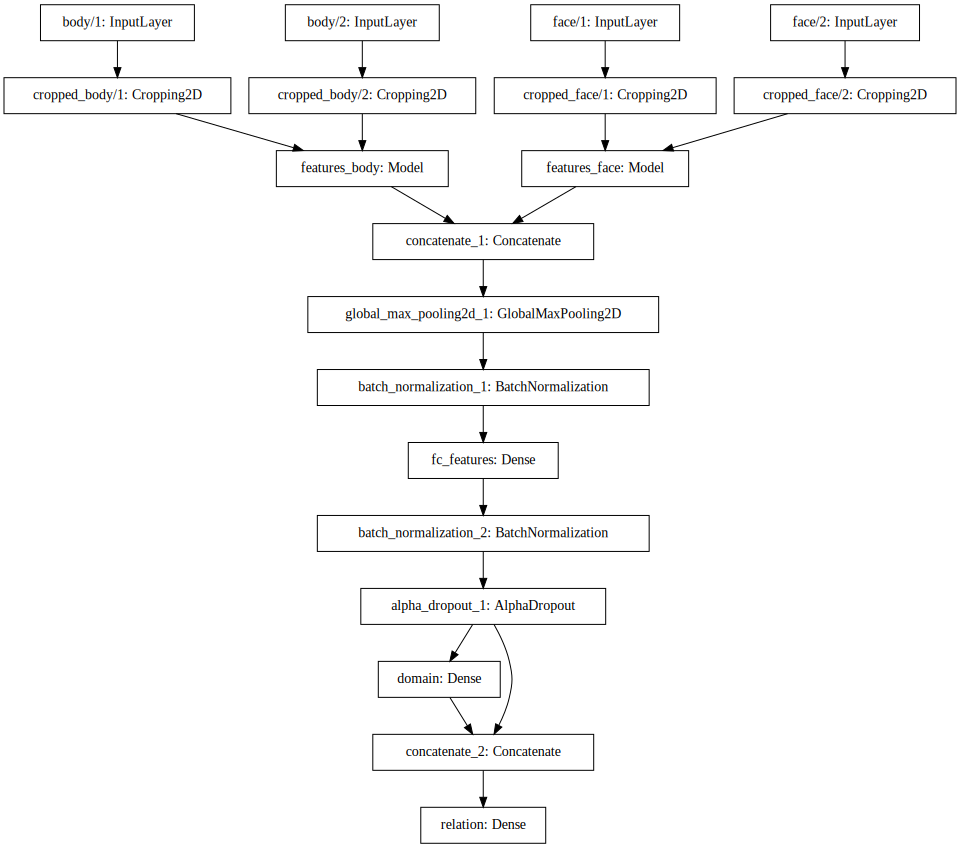

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
learning_rate = 0.0001

helper.set_model(
    model,
    optimizer=keras.optimizers.Adam(learning_rate, decay=1e-6),
    metrics=['accuracy'],
)

2018-02-21 17:11:48,634 - SocialClassifier - DEBUG - Initializing model.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
body/1 (InputLayer)             (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
body/2 (InputLayer)             (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
face/1 (InputLayer)             (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
face/2 (InputLayer)             (None, 256, 256, 3)  0                                            
____________________________________

# Training

In [ ]:
epochs = conf.EPOCHS

# checkpoint_path defined before
checkpointer = ModelCheckpoint( 
    filepath=checkpoint_path, monitor='val_loss',
    save_best_only=True, period=5,
)

lr_handler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
)

metrics_path = os.path.join(egosocial.config.MODELS_CACHE_DIR, 'training',
                            'metrics.csv')
csv_logger = CSVLogger(metrics_path)

plot_metrics = PlotLearning(update_step=1)

callbacks = [
    checkpointer,
    lr_handler,
    csv_logger,
    plot_metrics,
]

hist = helper.fit(
    steps_per_epoch=np.ceil(1.0 * n_train / batch_size),    
    validation_steps=np.ceil(1.0 * n_validation / batch_size),
    epochs=cache_epochs + epochs,
    initial_epoch=cache_epochs,
    callbacks=callbacks,
    use_multiprocessing=False,
    workers=8,
    max_queue_size=20,
    verbose=1,
)

2018-02-21 17:11:48,693 - SocialClassifier - DEBUG - Training model from scratch.
Epoch 1/30
125/215 [================>.............] - ETA: 3:16 - loss: 5.4391 - domain_loss: 2.2471 - relation_loss: 2.3853 - domain_acc: 0.2925 - relation_acc: 0.2184

# Evaluation

In [ ]:
scores = helper.model.evaluate_generator(
    helper._test_gen,
    steps=np.ceil(1.0 * n_test / batch_size),
    workers=8,
    max_queue_size=20,
)

for score, metric_name in zip(scores, helper.model.metrics_names):
    helper._log.info("{} : {:0.4}".format(metric_name, score))